<a href="https://colab.research.google.com/github/MWFK/Deep-Learning-From-Zero-To-Hero/blob/main/3_Arabic_MNIST_TransferLearning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
# Python packages to manipulate files
import os
import pathlib
from pathlib import Path
import datetime
# Tensorflow and Numpy packages
import tensorflow as tf
import numpy as np

# Display related packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import PIL
import PIL.Image

%matplotlib inline

# Compute capabilities
If you have a GPU uncomment the last line to check that your Tensorflow installation supports GPU

In [ ]:
#my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
#tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')
# #tf.config.set_visible_devices([], 'GPU')

# The image dataset

In [ ]:
# Create necessary folders
from os import mkdir
mkdir('/content/arabic_handwritten_data/')
mkdir('/content/arabic_handwritten_data/data/')
mkdir('/content/arabic_handwritten_data/data/test_data/')
mkdir('/content/arabic_handwritten_data/data/train_data/')

In [ ]:
# Use this code to uncompress the image dataset.
!tar xvzf '/content/arabic_handwritten_data.tgz' -C '/content/arabic_handwritten_data'

# We open a random file from the dataset and display it.
Image(filename = "/content/arabic_handwritten_data/data/test_data/id_10_label_5.png", width = 32, height = 32)

# We list the files inside each folder and we can see that we have thousands of png files that have a similar naming pattern. We can guess the letter to which the image belongs through the file name. We pick a random set of files and display their names.
directory = "/content/arabic_handwritten_data/data/train_data/"
images = os.listdir(directory)
images[0:12]

Streaming output truncated to the last 5000 lines.
data/train_data/id_8608_label_12.png
data/train_data/id_2106_label_12.png
data/train_data/id_10590_label_8.png
data/train_data/id_2818_label_17.png
data/train_data/id_7349_label_23.png
data/train_data/id_5289_label_18.png
data/train_data/id_3050_label_18.png
data/train_data/id_11114_label_18.png
data/train_data/id_192_label_24.png
data/train_data/id_6258_label_27.png
data/train_data/id_6579_label_11.png
data/train_data/id_9058_label_13.png
data/train_data/id_10945_label_25.png
data/train_data/id_8889_label_20.png
data/train_data/id_4557_label_10.png
data/train_data/id_5785_label_24.png
data/train_data/id_5074_label_19.png
data/train_data/id_7812_label_25.png
data/train_data/id_12978_label_27.png
data/train_data/id_325_label_13.png
data/train_data/id_9146_label_24.png
data/train_data/id_5488_label_14.png
data/train_data/id_7108_label_21.png
data/train_data/id_9379_label_25.png
data/train_data/id_3045_label_17.png
data/train_data/id_6935

['id_2505_label_6.png',
 'id_3020_label_14.png',
 'id_1565_label_28.png',
 'id_6167_label_15.png',
 'id_1331_label_27.png',
 'id_7365_label_25.png',
 'id_11090_label_15.png',
 'id_9893_label_5.png',
 'id_651_label_26.png',
 'id_6083_label_5.png',
 'id_10090_label_2.png',
 'id_8874_label_18.png']

# Displaying the data
We pick 12 images and display them in a grid using matplotlib.

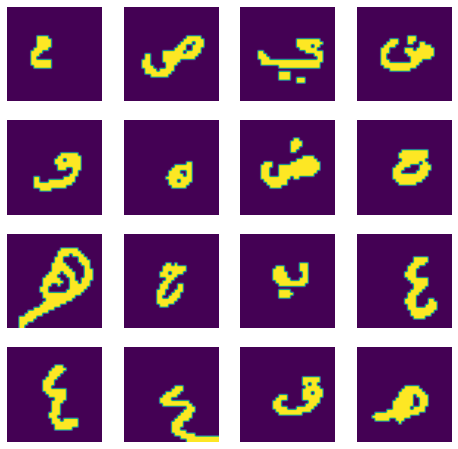

In [ ]:
ncols = 4
nrows = 4

fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

for i, img_path in enumerate(images[0:ncols*nrows]):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Disable axes display

    img = mpimg.imread(directory+img_path)
    plt.imshow(img)

plt.show()

# Define the data dictionary
To identify the model predictions easilly, we create a list identifing each label. The list contains the real name of the letter instead of just its index in the alphabet order. We provide two versions of this list:

the first one shows letters written in latin with phonetic representation.
the second one shows the letters in arabic.
For more details about arabic alphabet go to this Wikipedia page.

Our dataset is organized using the Common hijāʾī order.

In [ ]:
arabic_characters = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                    'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain',
                    'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']

arabic_char_utf8 = ("أ","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي")

len(arabic_characters)
print(arabic_characters[12])
print(arabic_char_utf8[12])

sheen
ش


# Load the data
We process the folder and load each files in it.

We extract the label of each picture and convert the image to a rescaled matrix of 32x32x3.

In [ ]:
batch_size = 32
img_height = 32
img_width = 32

def get_dataset(dataset_dir):
    
    def process_filename(file_path):
        # Replace elements of input matching regex pattern with rewrite.
        label = tf.strings.regex_replace( input = file_path, pattern = r".+_label_(\d+)\.png", rewrite = r"\1" )
        label = tf.strings.to_number(label, tf.int32)-1
        #label = tf.one_hot(label, depth=29)
        return label

    def process_img(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3) #  0: Use the number of channels in the PNG-encoded image. 1: output a grayscale image. 3: output an RGB image. 4: output an RGBA image.
        img = tf.image.resize(img, size=(32, 32))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.cast(img, tf.float32) / 255.0
        # The reason for normalizing the images is to avoid the possibility of exploding gradients because of the high range of the pixels [0, 255], and improve the convergence speed. 
        # Therefore, you either standardize each image, so that the range is [-1, 1] or you just divide by the maximum pixel value (255), so that the range of the pixels is in the [0, 1] range.
        # Another reason why you might want to normalize the image data is if you are using transfer learning. 
        # For example, if you are using a pre-trained model that has been trained with images with pixels in the [0, 1] range, you should make sure that the inputs you are providing the model are in the same range. 
        return img
    
    data_dir = pathlib.Path(dataset_dir)
    file_list = [ str( path.absolute() ) for path in Path(data_dir).glob("*.png") ] # find all the files in a directory having the extension .png using the for loop, then we'll have the absolute path in a string format
    # The simplest way to create a dataset is to create it from a python list
    files_ds = tf.data.Dataset.from_tensor_slices((file_list))
    # The map() method creates a new array populated with the results of calling a provided function on every element in the calling array.
    # A lambda function is a small anonymous function. A lambda function can take any number of arguments, but can only have one expression.
    files_ds = files_ds.map(lambda x: (process_img(x), process_filename(x))) # Couple the image processing with the names
    return files_ds

train_dataset_path = "/content/arabic_handwritten_data/data/train_data/"
test_dataset_path = "/content/arabic_handwritten_data/data/test_data/"

train_ds = get_dataset(train_dataset_path).shuffle(buffer_size=batch_size*10).batch(batch_size)
valid_ds = get_dataset(test_dataset_path).batch(batch_size)


# Define the neural network structure
In this example, we will use a pre-trained model (VGG16).

We will only train the last layers that allow us to fine tune the model to our prediction task.

In [ ]:
# VGG16 (also called OxfordNet) is a convolutional neural network architecture named after the Visual Geometry Group from Oxford, who developed it. It was used to win the ILSVR (ImageNet) competition in 2014. ... 
# The model loads a set of weights pre-trained on ImageNet.
# VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database. 
# The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(32,32,3),
                                        input_tensor=None,
                                        include_top=False,
                                        weights='imagenet')
VGG16_MODEL.trainable=False

# VGG16_MODEL.trainable = True
# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in VGG16_MODEL.layers[:fine_tune_at]:
#   layer.trainable =  False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(29,activation='softmax')

model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,
  prediction_layer
])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 29)                14877     
Total params: 14,729,565
Trainable params: 14,877
Non-trainable params: 14,714,688
_________________________________________________________________


# Compile the model
In order to compile the model we need to set the optimizer and the loss. We can also define metrics to track.

In this example, we use SparseCategoricalCrossentropy because the label is defined as a number.

If we use a one hot vector instead, we should use CategoricalCrossentropy.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Define callbacks
Tensorflow provides a callback mechanism that allows us to execute different tasks during the training like collecting statistics for Tensorboard.

In [ ]:
callbacks = [
     tf.keras.callbacks.EarlyStopping(
         # Stop training when `val_loss` is no longer improving
         monitor="val_loss",
         # "no longer improving" being defined as "no better than 1e-2 less"
         min_delta=1e-2,
         # "no longer improving" being further defined as "for at least 2 epochs"
         patience=2,
         verbose=1,
     )
 ]

#callbacks = [
#    tf.keras.callbacks.TensorBoard(
#        log_dir=logdir,
#        histogram_freq=0,  # How often to log histogram visualizations
#        embeddings_freq=0,  # How often to log embedding visualizations
#        update_freq="epoch",
#    ) 
#]

# Launch the training.
You can see the progress of the training in the output below or in the Tensorboard widget loaded earlier.

In [ ]:
print("Fit model on training data")
history = model.fit(train_ds, epochs = 50, validation_data=valid_ds, callbacks = callbacks)

Fit model on training data
Epoch 1/50
420/420 [==============================] - 9s 21ms/step - loss: 3.2656 - sparse_categorical_accuracy: 0.2132 - val_loss: 3.1745 - val_sparse_categorical_accuracy: 0.3283
Epoch 2/50
420/420 [==============================] - 9s 20ms/step - loss: 3.1310 - sparse_categorical_accuracy: 0.3854 - val_loss: 3.0887 - val_sparse_categorical_accuracy: 0.4354
Epoch 3/50
420/420 [==============================] - 8s 20ms/step - loss: 3.0574 - sparse_categorical_accuracy: 0.4737 - val_loss: 3.0316 - val_sparse_categorical_accuracy: 0.4917
Epoch 4/50
420/420 [==============================] - 8s 20ms/step - loss: 3.0133 - sparse_categorical_accuracy: 0.5030 - val_loss: 3.0010 - val_sparse_categorical_accuracy: 0.5065
Epoch 5/50
420/420 [==============================] - 8s 20ms/step - loss: 2.9876 - sparse_categorical_accuracy: 0.5137 - val_loss: 2.9800 - val_sparse_categorical_accuracy: 0.5229
Epoch 6/50
420/420 [==============================] - 8s 20ms/step -